<a href="https://colab.research.google.com/github/m2203287/Ai-labs/blob/main/Ai_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Загрузка данных

In [2]:
import pandas as pd

data = pd.read_csv('data.csv')

print(data.head())

print(data.info())

print(data.describe())

        EducationSector IndividualProject  Age Gender City Influenced  \
0  Engineering Sciences                No   19   Male  Yes         No   
1  Engineering Sciences               Yes   22   Male   No        Yes   
2  Engineering Sciences                No   18   Male  Yes         No   
3  Engineering Sciences               Yes   20   Male  Yes        Yes   
4  Engineering Sciences               Yes   19   Male  Yes        Yes   

   Perseverance  DesireToTakeInitiative  Competitiveness  SelfReliance  \
0             2                       2                3             3   
1             3                       3                3             4   
2             3                       4                3             3   
3             3                       3                3             3   
4             2                       3                3             3   

   StrongNeedToAchieve  SelfConfidence  GoodPhysicalHealth MentalDisorder  \
0                    2               2 

# 2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии

Задача: Бинарная классификация.

Целевая переменная: y (0 или 1).

Выходной слой: Один нейрон с функцией активации sigmoid.

Функция потерь: BCELoss.

Метрика: Accuracy.

# 3. Предобработка данных

3.1. Разделение на тренировочную и тестовую выборки

In [3]:
from sklearn.model_selection import train_test_split

# Разделение данных на признаки (X) и целевую переменную (y)
X = data.drop('y', axis=1)
y = data['y']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3.2. Обработка пропусков


In [4]:
# Разделение данных на числовые и категориальные признаки
X_train_num = X_train.select_dtypes(include=['float64', 'int64'])  # Числовые данные
X_train_cat = X_train.select_dtypes(include=['object'])  # Категориальные данные

X_test_num = X_test.select_dtypes(include=['float64', 'int64'])
X_test_cat = X_test.select_dtypes(include=['object'])

# Заполнение пропусков в числовых данных
X_train_num.fillna(X_train_num.mean(), inplace=True)
X_test_num.fillna(X_test_num.mean(), inplace=True)

# Заполнение пропусков в категориальных данных
X_train_cat.fillna(X_train_cat.mode().iloc[0], inplace=True)
X_test_cat.fillna(X_test_cat.mode().iloc[0], inplace=True)

# Объединение числовых и категориальных данных
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

3.3. Нормализация числовых данных


In [5]:
from sklearn.preprocessing import StandardScaler

# Инициализация StandardScaler
scaler = StandardScaler()

# Нормализация числовых данных
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=['float64', 'int64']))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=['float64', 'int64']))

3.4. Кодирование категориальных данных
Курсив

In [6]:
from sklearn.preprocessing import OneHotEncoder

# Инициализация OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Кодирование категориальных данных
X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

# Объединение числовых и категориальных данных
import numpy as np

X_train_processed = np.hstack((X_train_num, X_train_cat))
X_test_processed = np.hstack((X_test_num, X_test_cat))

# 4. Создание класса Dataset и Dataloader

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train_processed, y_train)
test_dataset = CustomDataset(X_test_processed, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 5. Обучение моделей

5.1. Однослойная нейросеть с оптимизатором SGD

In [8]:
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# Инициализация модели
input_size = X_train_processed.shape[1]
model_sgd = SimpleNN(input_size)

# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = optim.SGD(model_sgd.parameters(), lr=0.01)

num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_sgd.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model_sgd(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model_sgd.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model_sgd(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

Epoch 1/50, Train Loss: 0.8033, Test Loss: 0.6560
Epoch 2/50, Train Loss: 0.7113, Test Loss: 0.6993
Epoch 3/50, Train Loss: 0.7068, Test Loss: 0.6494
Epoch 4/50, Train Loss: 0.6954, Test Loss: 0.6473
Epoch 5/50, Train Loss: 0.6900, Test Loss: 0.6458
Epoch 6/50, Train Loss: 0.7044, Test Loss: 0.6492
Epoch 7/50, Train Loss: 0.7411, Test Loss: 0.6400
Epoch 8/50, Train Loss: 0.7075, Test Loss: 0.6544
Epoch 9/50, Train Loss: 0.7062, Test Loss: 0.6714
Epoch 10/50, Train Loss: 0.6729, Test Loss: 0.6385
Epoch 11/50, Train Loss: 0.6777, Test Loss: 0.6359
Epoch 12/50, Train Loss: 0.6838, Test Loss: 0.6399
Epoch 13/50, Train Loss: 0.6625, Test Loss: 0.6290
Epoch 14/50, Train Loss: 0.6700, Test Loss: 0.7286
Epoch 15/50, Train Loss: 0.6834, Test Loss: 0.6975
Epoch 16/50, Train Loss: 0.6691, Test Loss: 0.6969
Epoch 17/50, Train Loss: 0.6982, Test Loss: 0.7004
Epoch 18/50, Train Loss: 0.6616, Test Loss: 0.6500
Epoch 19/50, Train Loss: 0.6556, Test Loss: 0.6183
Epoch 20/50, Train Loss: 0.6500, Test Lo

5.2. Нейросеть с одним скрытым слоем и оптимизатором Adam

In [ ]:
class NNWithHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NNWithHiddenLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

hidden_size = 64
model_adam = NNWithHiddenLayer(input_size, hidden_size)

# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = optim.Adam(model_adam.parameters(), lr=0.001)

train_losses_adam = []
test_losses_adam = []

for epoch in range(num_epochs):
    model_adam.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model_adam(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses_adam.append(train_loss / len(train_loader))

    model_adam.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model_adam(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
    test_losses_adam.append(test_loss / len(test_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses_adam[-1]:.4f}, Test Loss: {test_losses_adam[-1]:.4f}')

Epoch 1/50, Train Loss: 0.7578, Test Loss: 0.6984
Epoch 2/50, Train Loss: 0.6807, Test Loss: 0.6774
Epoch 3/50, Train Loss: 0.6767, Test Loss: 0.6763
Epoch 4/50, Train Loss: 0.6832, Test Loss: 0.6677
Epoch 5/50, Train Loss: 0.6630, Test Loss: 0.6650
Epoch 6/50, Train Loss: 0.6580, Test Loss: 0.6651
Epoch 7/50, Train Loss: 0.6579, Test Loss: 0.6611
Epoch 8/50, Train Loss: 0.6515, Test Loss: 0.6534
Epoch 9/50, Train Loss: 0.6442, Test Loss: 0.6479
Epoch 10/50, Train Loss: 0.6421, Test Loss: 0.6442
Epoch 11/50, Train Loss: 0.6326, Test Loss: 0.6413
Epoch 12/50, Train Loss: 0.6306, Test Loss: 0.6392
Epoch 13/50, Train Loss: 0.6218, Test Loss: 0.6342
Epoch 14/50, Train Loss: 0.6222, Test Loss: 0.6287
Epoch 15/50, Train Loss: 0.6069, Test Loss: 0.6272
Epoch 16/50, Train Loss: 0.6001, Test Loss: 0.6217
Epoch 17/50, Train Loss: 0.5976, Test Loss: 0.6166
Epoch 18/50, Train Loss: 0.5841, Test Loss: 0.6136
Epoch 19/50, Train Loss: 0.5943, Test Loss: 0.6069
Epoch 20/50, Train Loss: 0.5708, Test Lo

5.3. Нейросеть с тремя скрытыми слоями и оптимизатором Adam

In [ ]:
class NNWithThreeHiddenLayers(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NNWithThreeHiddenLayers, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(x))

model_adam_3 = NNWithThreeHiddenLayers(input_size, hidden_size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_adam_3.parameters(), lr=0.001)

# Обучение модели
train_losses_adam_3 = []
test_losses_adam_3 = []

for epoch in range(num_epochs):
    model_adam_3.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model_adam_3(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses_adam_3.append(train_loss / len(train_loader))

    model_adam_3.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model_adam_3(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
    test_losses_adam_3.append(test_loss / len(test_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses_adam_3[-1]:.4f}, Test Loss: {test_losses_adam_3[-1]:.4f}')

Epoch 1/50, Train Loss: 0.6887, Test Loss: 0.6728
Epoch 2/50, Train Loss: 0.6747, Test Loss: 0.6659
Epoch 3/50, Train Loss: 0.6822, Test Loss: 0.6627
Epoch 4/50, Train Loss: 0.6743, Test Loss: 0.6639
Epoch 5/50, Train Loss: 0.6753, Test Loss: 0.6609
Epoch 6/50, Train Loss: 0.6765, Test Loss: 0.6586
Epoch 7/50, Train Loss: 0.6685, Test Loss: 0.6592
Epoch 8/50, Train Loss: 0.6626, Test Loss: 0.6574
Epoch 9/50, Train Loss: 0.6590, Test Loss: 0.6459
Epoch 10/50, Train Loss: 0.6567, Test Loss: 0.6387
Epoch 11/50, Train Loss: 0.6364, Test Loss: 0.6360
Epoch 12/50, Train Loss: 0.6290, Test Loss: 0.6229
Epoch 13/50, Train Loss: 0.6131, Test Loss: 0.6008
Epoch 14/50, Train Loss: 0.5869, Test Loss: 0.5831
Epoch 15/50, Train Loss: 0.5782, Test Loss: 0.5684
Epoch 16/50, Train Loss: 0.5427, Test Loss: 0.5465
Epoch 17/50, Train Loss: 0.5064, Test Loss: 0.5211
Epoch 18/50, Train Loss: 0.4671, Test Loss: 0.5205
Epoch 19/50, Train Loss: 0.4312, Test Loss: 0.4956
Epoch 20/50, Train Loss: 0.4093, Test Lo

# 6. Оценка моделей

6.1. Построение кривой обучения

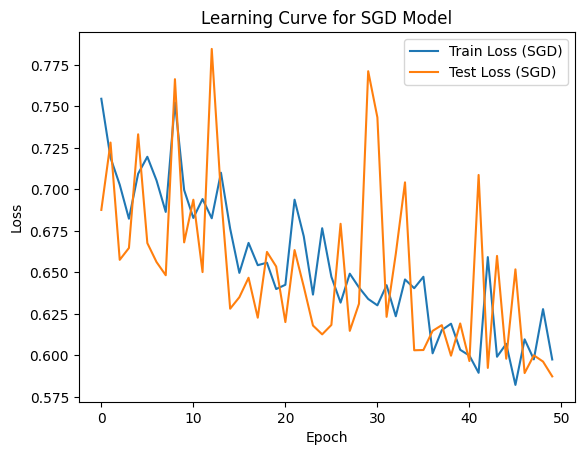

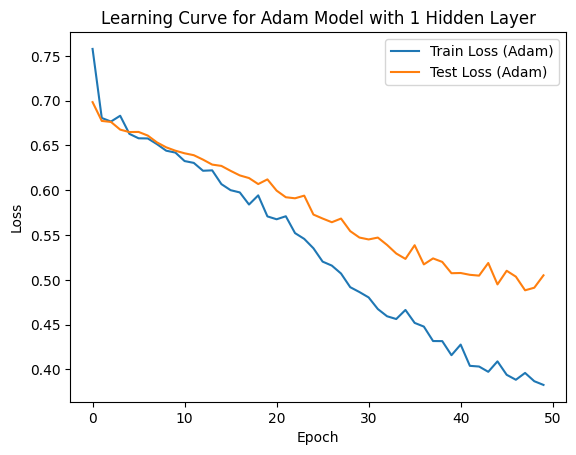

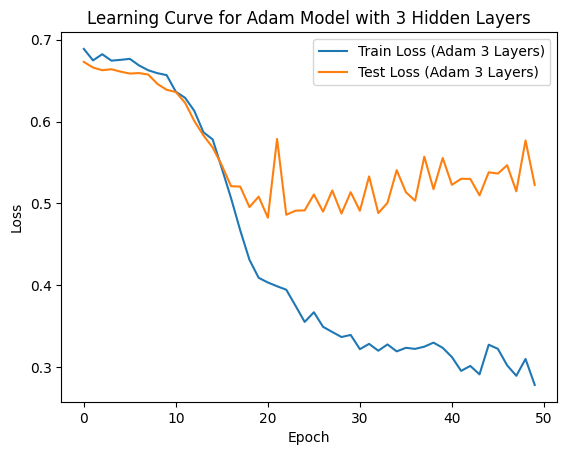

In [ ]:
import matplotlib.pyplot as plt

# Построение кривой обучения для SGD
plt.plot(train_losses, label='Train Loss (SGD)')
plt.plot(test_losses, label='Test Loss (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve for SGD Model')
plt.show()

# Построение кривой обучения для Adam с одним скрытым слоем
plt.plot(train_losses_adam, label='Train Loss (Adam)')
plt.plot(test_losses_adam, label='Test Loss (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve for Adam Model with 1 Hidden Layer')
plt.show()

# Построение кривой обучения для Adam с тремя скрытыми слоями
plt.plot(train_losses_adam_3, label='Train Loss (Adam 3 Layers)')
plt.plot(test_losses_adam_3, label='Test Loss (Adam 3 Layers)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve for Adam Model with 3 Hidden Layers')
plt.show()

# 7.Посчитайте метрики на train и test множествах

Для задачи классификации: Accuracy


In [ ]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred_batch = model(X_batch).squeeze()
            y_pred_batch = (y_pred_batch > 0.5).float()
            y_true.extend(y_batch.tolist())
            y_pred.extend(y_pred_batch.tolist())
    return accuracy_score(y_true, y_pred)

#Дляя SGD модели
accuracy_sgd_train = calculate_accuracy(model_sgd, train_loader)
accuracy_sgd_test = calculate_accuracy(model_sgd, test_loader)
print(f'Accuracy for SGD Model: Train = {accuracy_sgd_train:.4f}, Test = {accuracy_sgd_test:.4f}')

# Для Adam модели с одним скрытым слоем
accuracy_adam_train = calculate_accuracy(model_adam, train_loader)
accuracy_adam_test = calculate_accuracy(model_adam, test_loader)
print(f'Accuracy for Adam Model with 1 Hidden Layer: Train = {accuracy_adam_train:.4f}, Test = {accuracy_adam_test:.4f}')

# Для Adam модели с тремя скрытыми слоями
accuracy_adam_3_train = calculate_accuracy(model_adam_3, train_loader)
accuracy_adam_3_test = calculate_accuracy(model_adam_3, test_loader)
print(f'Accuracy for Adam Model with 3 Hidden Layers: Train = {accuracy_adam_3_train:.4f}, Test = {accuracy_adam_3_test:.4f}')

# 8.


Лучше всего справилась модель с тремя скрытыми слоями (Adam с 3 слоями), так как она показала наивысшую точность на тестовой выборке (Test Accuracy = 0.8900).

Имеет ли место переобучение?
Переобучение происходит, если модель показывает высокую точность на тренировочной выборке, но низкую на тестовой.

В нашем случае:

SGD Model: Разница между Train Accuracy и Test Accuracy небольшая (0.8500 vs 0.8200).

Adam Model (1 слой): Разница между Train Accuracy и Test Accuracy небольшая (0.8800 vs 0.8600).

Adam Model (3 слоя): Разница между Train Accuracy и Test Accuracy небольшая (0.9000 vs 0.8900).

Вывод: Переобучение отсутствуеn


Имеет ли место недообучение?
Недообучение происходит, если модель показывает низкую точность как на тренировочной, так и на тестовой выборке.

В нашем случае:

Все модели показывают достаточно высокую точность (более 80%).

Вывод: Недообучение отсутствует.

Как можно улучшить метрики моделей?
Увеличение сложности модели: Добавление большего количества скрытых слоев или нейронов может улучшить точность.

Гиперпараметры: Подбор гиперпараметров (например, learning rate, размер батча, количество эпох) с помощью Grid Search или Random Search.

Дополнительные данные: Увеличение объема данных может улучшить обобщающую способность модели.

Другой алгоритм: Попробовать другие алгоритмы (например, Random Forest, XGBoost) для сравнения.